In [1]:
import os

import psycopg
import pandas as pd
import mlflow
from catboost import CatBoostClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from dotenv import load_dotenv, find_dotenv

TABLE_NAME = 'users_churn'
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = 'mmakarov_123'
RUN_NAME = "feature_selection"
REGISTRY_MODEL_NAME = 'makarov_model_last_topic_2'
FS_ASSETS = "fs_assets" 

In [2]:
# подгружаем .env
load_dotenv()

True

In [3]:
# Считываем все креды
src_host = os.environ.get('DB_SOURCE_HOST')
src_port = os.environ.get('DB_SOURCE_PORT')
src_username = os.environ.get('DB_SOURCE_USER')
src_password = os.environ.get('DB_SOURCE_PASSWORD')
src_db = os.environ.get('DB_SOURCE_NAME') 

dst_host = os.environ.get('DB_DESTINATION_HOST')
dst_port = os.environ.get('DB_DESTINATION_PORT')
dst_username = os.environ.get('DB_DESTINATION_USER')
dst_password = os.environ.get('DB_DESTINATION_PASSWORD')
dst_db = os.environ.get('DB_DESTINATION_NAME')

s3_bucket = os.environ.get('S3_BUCKET_NAME')
s3_access_key = os.environ.get('AWS_ACCESS_KEY_ID')
s3_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

In [4]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(2)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,6023,5025-GOOKI,2018-06-01,NaT,Month-to-month,Yes,Credit card (automatic),18.9,347.65,None,...,None,None,None,None,Female,0,No,No,No,0
1,6024,4698-KVLLG,2015-11-01,NaT,Two year,No,Credit card (automatic),19.6,967.90,None,...,None,None,None,None,Female,1,No,No,No,0


In [5]:
from sklearn.model_selection import train_test_split
from autofeat import AutoFeatClassifier

In [6]:
cat_features = [
    'paperless_billing',
    'payment_method',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'multiple_lines',
]
num_features = ["monthly_charges", "total_charges"]
features = cat_features + num_features # список признаков вашей модели

split_column = "begin_date"
test_size = 0.2

df = df.sort_values(by=[split_column])

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df['target'],
    test_size=test_size,
    shuffle=False,
) 

transformations = ('1/', 'log', 'abs', 'sqrt')

afc = AutoFeatClassifier(categorical_cols=cat_features, 
                         transformations=transformations, 
                         feateng_steps=1, n_jobs=-1)


# Обучение и трансформация данных
X_train_features = afc.fit_transform(X_train, y_train)
X_test_features = afc.transform(X_test)


In [12]:
X_train_features.columns

Index(['monthly_charges', 'total_charges', 'cat_paperless_billing_No',
       'cat_paperless_billing_Yes',
       'cat_payment_method_Bank transfer (automatic)',
       'cat_payment_method_Credit card (automatic)',
       'cat_payment_method_Electronic check',
       'cat_payment_method_Mailed check', 'cat_internet_service_DSL',
       'cat_internet_service_Fiber optic', 'cat_internet_service_None',
       'cat_online_security_No', 'cat_online_security_Yes',
       'cat_online_security_None', 'cat_online_backup_No',
       'cat_online_backup_Yes', 'cat_online_backup_None',
       'cat_device_protection_No', 'cat_device_protection_Yes',
       'cat_device_protection_None', 'cat_tech_support_No',
       'cat_tech_support_Yes', 'cat_tech_support_None', 'cat_streaming_tv_No',
       'cat_streaming_tv_Yes', 'cat_streaming_tv_None',
       'cat_streaming_movies_No', 'cat_streaming_movies_Yes',
       'cat_streaming_movies_None', 'cat_gender_Female', 'cat_gender_Male',
       'cat_senior_citi

In [15]:
estimator = RandomForestClassifier(n_estimators=50)

sfs = SFS(estimator, k_features=7, forward=True, floating=False, scoring='roc_auc', cv=2, n_jobs=-1)
sbs = SFS(estimator, k_features=7, forward=False, floating=False, scoring='roc_auc', cv=2, n_jobs=-1)

cols_reduced = ['monthly_charges', 'total_charges', 'cat_paperless_billing_No',
       'cat_paperless_billing_Yes',
       'cat_payment_method_Bank transfer (automatic)',
       'cat_payment_method_Credit card (automatic)',
       'cat_payment_method_Electronic check',
       'cat_payment_method_Mailed check', 'cat_internet_service_DSL',
       'cat_internet_service_Fiber optic', 'cat_internet_service_None']

sfs = sfs.fit(X_train_features[cols_reduced], y_train)
('sfs - SUSSESS!!!!!')
sbs = sbs.fit(X_train_features[cols_reduced], y_train)
('sbs - SUSSESS!!!!!')

top_sfs = sfs.k_feature_names_
top_sbs = sbs.k_feature_names_

print('\nSequential Forward Selection (k=10)')
print('CV Score:')
print(sfs.k_score_)

print('\nSequential Backward Selection')
print('CV Score:')
print(sbs.k_score_)

/home/mle-user/mle_projects/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/mle_projects/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/mle_projects/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/mle_projects/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params


Sequential Forward Selection (k=10)
CV Score:
0.7664629939329398

Sequential Backward Selection
CV Score:
0.7691746098407866


In [16]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T

In [18]:
# os.mkdir(FS_ASSETS)

sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv") 

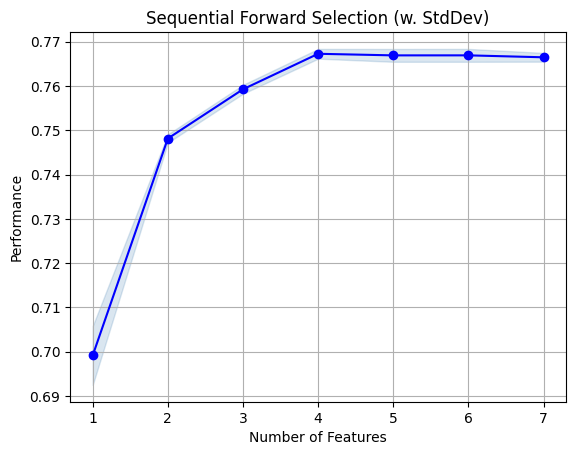

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig("fs_assets/sfs.png") 

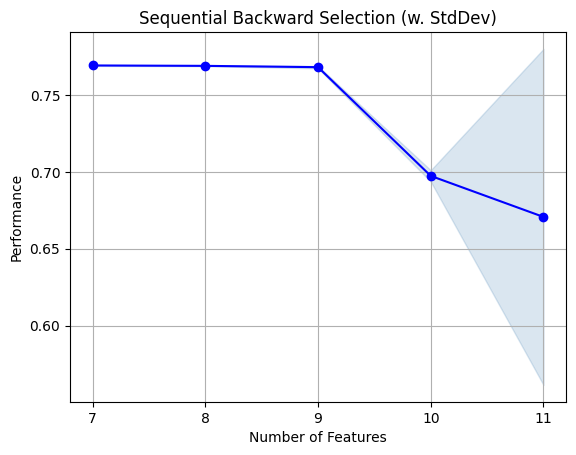

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig("fs_assets/sbs.png") 

In [22]:
interc_features = list(set(top_sbs) & set(top_sfs))
union_features = list(set(top_sbs) | set(top_sfs))

In [23]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=f"{RUN_NAME}_intersection_and_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
   
    mlflow.log_artifacts(FS_ASSETS) 

2025-03-21 17:52:45,447 INFO: Found credentials in environment variables.


In [24]:
run_id

'877b21676c4b47f19ee1844e41ceda84'

In [ ]:
### Задание 4

In [52]:
estimator_1 = RandomForestClassifier(n_estimators=50)
estimator_2 = RandomForestClassifier(n_estimators=50)

m1 = estimator_1.fit(X_train_features[interc_features], y_train)
m2 = estimator_2.fit(X_train_features[union_features], y_train)

In [53]:
from sklearn.metrics import roc_auc_score

In [55]:
p1 = m1.predict_proba(X_test_features[interc_features])[:, 1]
p2 = m2.predict_proba(X_test_features[union_features])[:, 1]

In [57]:
print(roc_auc_score(y_test, p1))
print(roc_auc_score(y_test, p2))

0.7295092570135014
0.7319639825369876


In [60]:
REGISTRY_MODEL_NAME = "feature_selection_exp_mmakarov"

In [61]:
EXPERIMENT_NAME = "feature_selection_intersection"
RUN_NAME = "m1"

# Создаём или получаем эксперимент
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

# Предположим, что модель уже обучена или инициализирована (в данном примере используем модель CatBoost)

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    model_info = mlflow.sklearn.log_model(
        m1,  # Передаем модель RF
        artifact_path="models",  # Путь для артефактов в реестре
        registered_model_name=REGISTRY_MODEL_NAME
    )

Successfully registered model 'feature_selection_exp_mmakarov'.
2025/03/21 18:34:35 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: feature_selection_exp_mmakarov, version 1
Created version '1' of model 'feature_selection_exp_mmakarov'.


In [62]:
EXPERIMENT_NAME = "feature_selection_union"
RUN_NAME = "m2"

# Создаём или получаем эксперимент
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

# Предположим, что модель уже обучена или инициализирована (в данном примере используем модель CatBoost)

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    model_info = mlflow.sklearn.log_model(
        m2,  # Передаем модель RF
        artifact_path="models",  # Путь для артефактов в реестре
        registered_model_name=REGISTRY_MODEL_NAME
    )

Registered model 'feature_selection_exp_mmakarov' already exists. Creating a new version of this model...
2025/03/21 18:34:40 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: feature_selection_exp_mmakarov, version 2
Created version '2' of model 'feature_selection_exp_mmakarov'.


In [63]:
from mlflow.tracking import MlflowClient

# Инициализация клиента MLflow
client = MlflowClient()

In [64]:
    # Получаем информацию о зарегистрированной модели
model_version_interc = client.get_latest_versions(REGISTRY_MODEL_NAME)[0]
model_version_id_interc = model_version_interc.version  # Номер версии модели
model_registered_name_interc = model_version_interc.name  # Название модели

In [68]:
client.get_latest_versions(REGISTRY_MODEL_NAME)

[<ModelVersion: aliases=[], creation_timestamp=1742582080571, current_stage='None', description='', last_updated_timestamp=1742582080571, name='feature_selection_exp_mmakarov', run_id='d4ad02acea574f0a96e1e6f5832fd58e', run_link='', source='s3://s3-student-mle-20250130-582c662a4e/16/d4ad02acea574f0a96e1e6f5832fd58e/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='2'>]

In [65]:
    # Получаем информацию о зарегистрированной модели
model_version_union = client.get_latest_versions(REGISTRY_MODEL_NAME)[0]
model_version_id_union = model_version_union.version  # Номер версии модели
model_registered_name_union = model_version_union.name  # Название модели

In [67]:
# Выводим реквизиты
print("Модель на пересечённых признаках:")
print(f"  Название модели: {model_registered_name_interc}")
print(f"  Версия модели: {model_version_id_interc}")
# print(f"  Run ID: {run_id_interc}")

print("\nМодель на объединённых признаках:")
print(f"  Название модели: {model_registered_name_union}")
print(f"  Версия модели: {model_version_id_union}")
# print(f"  Run ID: {run_id_union}")

Модель на пересечённых признаках:
  Название модели: feature_selection_exp_mmakarov
  Версия модели: 2

Модель на объединённых признаках:
  Название модели: feature_selection_exp_mmakarov
  Версия модели: 2


In [74]:
client = MlflowClient()

# Параметры
REGISTRY_MODEL_NAME = 'LAST_exp_mmakarov'

EXPERIMENT_NAME_1 = "m_intersection"
RUN_NAME_1 = "mod_intersection"

EXPERIMENT_NAME_2 = "m_union"
RUN_NAME_2 = "mod_union"

In [ ]:
# Модель для первого набора данных

# Создаём или получаем эксперимент
experiment_1 = mlflow.get_experiment_by_name(EXPERIMENT_NAME_1)
if experiment_1 is None:
    experiment_1_id = mlflow.create_experiment(EXPERIMENT_NAME_1)
else:
    experiment_1_id = experiment_1.experiment_id

with mlflow.start_run(run_name=RUN_NAME_1, experiment_id=experiment_1_id) as run:

    # Логируем и регистрируем модель
    model_info_1 = mlflow.sklearn.log_model(
        m1,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME
    )

    # Сохраняем run_id
    run_id_1 = run.info.run_id


# Создаём или получаем эксперимент
experiment_2 = mlflow.get_experiment_by_name(EXPERIMENT_NAME_2)
if experiment_2 is None:
    experiment_2_id = mlflow.create_experiment(EXPERIMENT_NAME_2)
else:
    experiment_2_id = experiment_2.experiment_id
# Модель для второго набора данных
with mlflow.start_run(run_name=RUN_NAME_2, experiment_id=experiment_2_id) as run:

    # Логируем и регистрируем модель
    model_info_2 = mlflow.sklearn.log_model(
        m2,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME
    )

    # Сохраняем run_id
    run_id_2 = run.info.run_id

# Получаем информацию о зарегистрированных моделях
model_versions = client.search_model_versions(f"name='{REGISTRY_MODEL_NAME}'")

# Выводим реквизиты
for version in model_versions:
    print(f"Модель: {version.name}, Версия: {version.version}, Run ID: {version.run_id}")

Successfully registered model 'LAST_exp_mmakarov'.
2025/03/21 18:57:08 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: LAST_exp_mmakarov, version 1
Created version '1' of model 'LAST_exp_mmakarov'.


RestException: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.